# Convolution Image Net

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from utils.nn_visualization import variable_summaries
from utils.data import init_model_logging
from utils.nn_graph import simple_layer
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import pandas as pd
import matplotlib.pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [4]:
data = input_data.read_data_sets('/data/fashion/', one_hot=True)
img_shape = (28, 28)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting /data/fashion/train-images-idx3-ubyte.gz
Extracting /data/fashion/train-labels-idx1-ubyte.gz
Extracting /data/fashion/t10k-images-idx3-ubyte.gz
Extracting /data/fashion/t10k-labels-idx1-ubyte.gz


## Custom Layer Functions

In [6]:
def conv_layer(name, input_data, 
               conv_filter_shape, pooling_filter_shape, 
               conv_filter_stride=[1, 1, 1, 1], 
               pooling_filter_stride=[1, 1, 1, 1],
               padding='SAME'):
    w_name = 'w_' + name
    b_name = 'b_' + name
    
    # Variables initialization
    w = tf.get_variable(w_name, conv_filter_shape, initializer=tf.contrib.layers.variance_scaling_initializer())
    bias = tf.get_variable(b_name, initializer=tf.constant_initializer(0), shape=conv_filter_shape[-1])

    # Convolution part
    conv_layer = tf.nn.conv2d(input_data, w, strides=conv_filter_stride, padding=padding)
    conv_layer = conv_layer + bias
    conv_layer = tf.nn.relu(conv_layer)

    # Pooling part
    conv_layer = tf.nn.max_pool(conv_layer, 
                                ksize=pooling_filter_shape, 
                                strides=pooling_filter_stride, 
                                padding=padding)
    
    return conv_layer

## Build Conv Net Graph

In [9]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('conv_image_net_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
        keep_dropout_prob = tf.placeholder(tf.float32, name='keep_dropout_prob')
            
    with tf.name_scope('image_reshape'):        
        images_reshaped = tf.reshape(images, [-1, 28, 28, 1])

    with tf.variable_scope('conv_layer_1'):
        conv_layer_1 = conv_layer('cl_1', images_reshaped, 
               conv_filter_shape=[3, 3, 1, 32], conv_filter_stride=[1, 1, 1, 1], 
               pooling_filter_shape=[1, 2, 2, 1], pooling_filter_stride=[1, 2, 2, 1],
               padding='SAME')  

    with tf.variable_scope('conv_layer_2'):
        conv_layer_2 = conv_layer('cl_2', conv_layer_1, 
               conv_filter_shape=[3, 3, 32, 64], conv_filter_stride=[1, 1, 1, 1], 
               pooling_filter_shape=[1, 2, 2, 1], pooling_filter_stride=[1, 2, 2, 1],
               padding='SAME') 
    
    with tf.variable_scope('feed_forward_layer_1'):
        ff_layer_1 = tf.reshape(conv_layer_2, [-1, 7*7*64])
        ff_layer_1 = simple_layer('ff_1', ff_layer_1, shape=[7*7*64, 10], activation='linear')
        raw_prediction = tf.nn.dropout(ff_layer_1, keep_dropout_prob)
    
    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)

    with tf.name_scope('loss'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=raw_prediction)
        loss = tf.reduce_mean(cross_entropy_vector)
        
    with tf.name_scope('training'):
        train_step  = tf.train.AdamOptimizer(1e-3).minimize(loss)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
    
    initialize_vars = tf.global_variables_initializer()

## Tensorflow

In [11]:
validation_feed_dict = {
    images: data.validation.images, 
    labels: data.validation.labels,
    keep_dropout_prob: 1.}

session = tf.Session(graph=graph)
session.run(initialize_vars)

for iteration in range(5001):
    ##################
    # Training Phase #
    ##################
    
    _images, _labels = data.train.next_batch(100)
    feed_dict = {images: _images, labels: _labels, keep_dropout_prob: 0.5}
    _ = session.run([train_step], feed_dict=feed_dict)
 

    #################
    # Logging Phase #
    #################

    if iteration % 100 == 0:
        _accuracy, _loss = session.run([accuracy, loss], validation_feed_dict)
        print("= Valid Iteration {}: loss {}, accuracy {} =".format(iteration, _loss, _accuracy))

= Valid Iteration 0: loss 2.1454453468322754, accuracy 0.27140000462532043 =
= Valid Iteration 100: loss 0.5987183451652527, accuracy 0.8087999820709229 =
= Valid Iteration 200: loss 0.4659445285797119, accuracy 0.8669999837875366 =
= Valid Iteration 300: loss 0.43911466002464294, accuracy 0.8669999837875366 =
= Valid Iteration 400: loss 0.4140065312385559, accuracy 0.8808000087738037 =
= Valid Iteration 500: loss 0.41776636242866516, accuracy 0.8772000074386597 =
= Valid Iteration 600: loss 0.38928329944610596, accuracy 0.8758000135421753 =
= Valid Iteration 700: loss 0.36727532744407654, accuracy 0.8889999985694885 =
= Valid Iteration 800: loss 0.36090147495269775, accuracy 0.8948000073432922 =
= Valid Iteration 900: loss 0.3949769139289856, accuracy 0.8708000183105469 =
= Valid Iteration 1000: loss 0.3371403217315674, accuracy 0.901199996471405 =
= Valid Iteration 1100: loss 0.3298799395561218, accuracy 0.8992000222206116 =
= Valid Iteration 1200: loss 0.3316366672515869, accuracy 0

In [12]:
_prediction, = session.run([prediction], feed_dict=validation_feed_dict)

In [13]:
session.close()

In [17]:
from utils.results_evaluation import get_info_df
from utils.results_evaluation import get_accuracy
from utils.results_evaluation import get_false_positives
from utils.results_evaluation import get_info_df
from utils.results_evaluation import get_rec_prec
from utils.results_evaluation import plot_coocurance_matrix
from utils.results_evaluation import plot_examples 

In [18]:
df = get_info_df(data.validation.labels, _prediction, class_id2class_name_mapping, data.validation.images)

In [19]:
get_accuracy(df)

91.46

In [20]:
get_rec_prec(df, class_id2class_name_mapping)

,class_name,precision,recall
0,T-shirt/top,88.10,80.96
1,Trouser,98.04,99.10
2,Pullover,86.32,85.12
3,Dress,87.43,95.81
4,Coat,83.99,87.09
5,Sandal,98.97,97.16
6,Shirt,78.71,74.24
7,Sneaker,95.11,98.83
8,Bag,98.16,97.76
9,Ankle boot,98.19,96.44


In [21]:
fp = get_false_positives(df, 'Shirt')

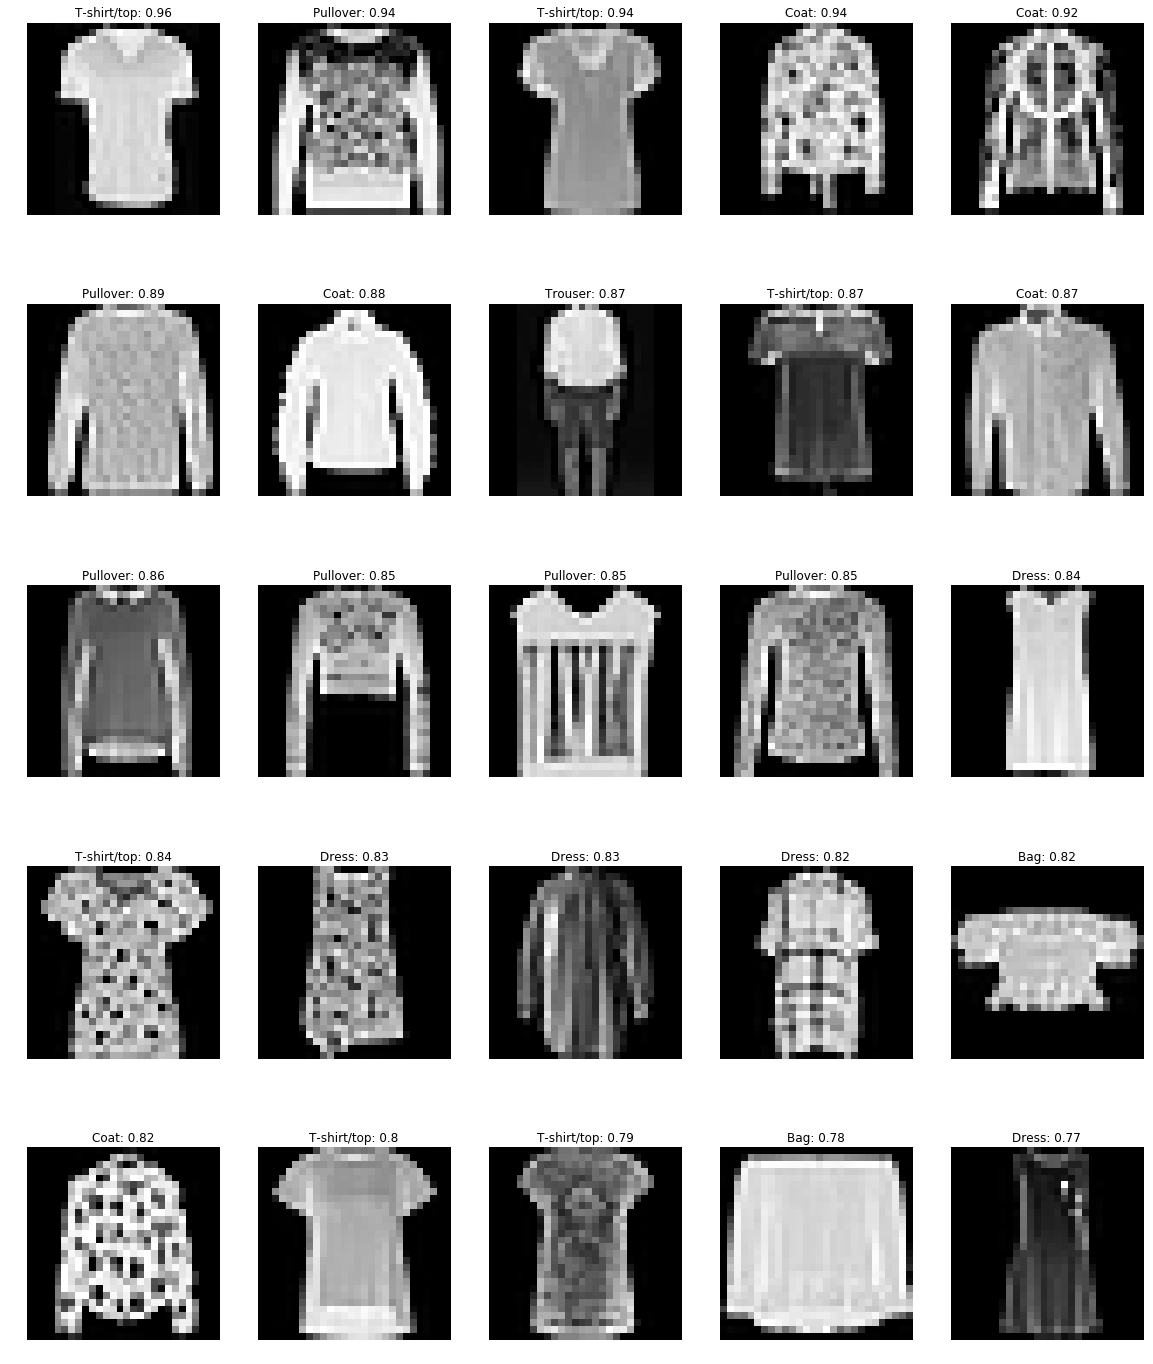

In [22]:
plot_examples(fp)

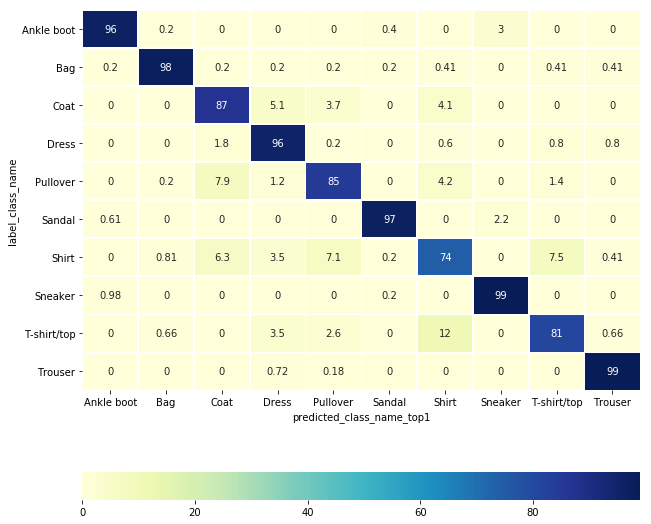

In [23]:
plot_coocurance_matrix(df, use_top3=False, use_log=False)